### Spatial Understanding with Qwen2.5-VL

This notebook showcases Qwen2.5-VL's advanced spatial localization abilities, including accurate object detection and specific target grounding within images. 

See how it integrates visual and linguistic understanding to interpret complex scenes effectively.

Prepare the environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install openai

^C


  Could not find a version that satisfies the requirement qwen-vl-utils (from versions: )
No matching distribution found for qwen-vl-utils


#### \[Setup\]

Load visualization utils.

In [1]:
# @title Plotting Util

import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def get_system_font(size=14):
    """获取系统可用字体，带有多级回退机制"""
    font_candidates = [
        "msyh.ttc",        # 微软雅黑（Windows）
        "simhei.ttf",      # 黑体（Windows）
        "Arial Unicode.ttf", # macOS/通用
        "arial.ttf",       # 通用
        None               # 最终回退到默认字体
    ]
    
    for font_file in font_candidates:
        try:
            return ImageFont.truetype(font_file, size=size) if font_file else ImageFont.load_default()
        except OSError:
            continue
    return ImageFont.load_default()

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """
    img = im
    width, height = img.size
    print(img.size)
    draw = ImageDraw.Draw(img)

    colors = [
        'red', 'green', 'blue', 'yellow', 'orange', 
        'pink', 'purple', 'brown', 'gray', 'beige',
        'turquoise', 'cyan', 'magenta', 'lime', 'navy',
        'maroon', 'teal', 'olive', 'coral', 'lavender',
        'violet', 'gold', 'silver'
    ] + additional_colors

    bounding_boxes = parse_json(bounding_boxes)
    font = get_system_font(14)  # 使用系统字体

    try:
        json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
        end_idx = bounding_boxes.rfind('"}') + len('"}')
        truncated_text = bounding_boxes[:end_idx] + "]"
        json_output = ast.literal_eval(truncated_text)

    for i, bounding_box in enumerate(json_output):
        color = colors[i % len(colors)]
        
        abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
        abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
        abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
        abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1
        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)
        
        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    #img.show()

def plot_points(im, text, input_width, input_height):
    img = im
    width, height = img.size
    draw = ImageDraw.Draw(img)
    
    colors = [
        'red', 'green', 'blue', 'yellow', 'orange', 
        'pink', 'purple', 'brown', 'gray', 'beige',
        'turquoise', 'cyan', 'magenta', 'lime', 'navy',
        'maroon', 'teal', 'olive', 'coral', 'lavender',
        'violet', 'gold', 'silver'
    ] + additional_colors
    
    xml_text = text.replace('```xml', '').replace('```', '')
    data = decode_xml_points(xml_text)
    
    if data is None:
        img.show()
        return
        
    points = data['points']
    description = data['phrase']
    font = get_system_font(14)  # 使用系统字体

    for i, point in enumerate(points):
        color = colors[i % len(colors)]
        abs_x1 = int(point[0])/input_width * width
        abs_y1 = int(point[1])/input_height * height
        radius = 2
        draw.ellipse([(abs_x1 - radius, abs_y1 - radius), 
                     (abs_x1 + radius, abs_y1 + radius)], fill=color)
        draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
    
    img.show()

def parse_json(json_output):
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])
            json_output = json_output.split("```")[0]
            break
    return json_output

Load model and processors.

Load inference function.

inference function with API

In [2]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="qwen2.5-vl-72b-instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        api_key="sk-f0e683a01d464b0bb790f34524463fc5",
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content


#### 1. Detect certain object in the image

Let's start with a simple scenario where we want to locate certain objects in an image.

Besides, we can further prompt the model to describe their unique characteristics or features by explicitly giving that order.

In [ ]:
import os
import json
import threading
from queue import Queue
from PIL import Image
from qwen_vl_utils import smart_resize

# 设置API密钥
os.environ['DASHSCOPE_API_KEY'] = 'sk-f0e683a01d464b0bb790f34524463fc5'

# 全局变量
min_pixels = 512 * 28 * 28
max_pixels = 2048 * 28 * 28
processed_count = 0
lock = threading.Lock()

def worker(task_queue, prompt):
    """工作线程函数，处理图片任务"""
    global processed_count
    
    while True:
        # 从队列获取任务
        image_path = task_queue.get()
        if image_path is None:  # 结束信号
            task_queue.put(None)  # 传递给其他线程
            break
        
        try:
            # 处理图片
            image = Image.open(image_path)
            width, height = image.size
            input_height, input_width = smart_resize(height, width, 
                                                   min_pixels=min_pixels, 
                                                   max_pixels=max_pixels)
            
            # 调用API进行推理
            response = inference_with_api(image_path, prompt, 
                                        min_pixels=min_pixels, 
                                        max_pixels=max_pixels)
            
            # 保存标注后的图片
            filename = os.path.basename(image_path)
            output_image_path = os.path.join('label_image', filename)
            plot_bounding_boxes(image, response, input_width, input_height)
            image.save(output_image_path)
            
            # 保存JSON数据
            json_data = {
                "filename": filename,
                "prompt": prompt,
                "response": response,
                "input_size": {"width": input_width, "height": input_height}
            }
            
            json_filename = os.path.splitext(filename)[0] + '.json'
            output_json_path = os.path.join('label_json', json_filename)
            
            with open(output_json_path, 'w', encoding='utf-8') as f:
                json.dump(json_data, f, ensure_ascii=False, indent=2)
            
            # 更新计数器
            with lock:
                processed_count += 1
                print(f"已完成 {processed_count} 张图片: {filename}")
                
        except Exception as e:
            print(f"处理 {image_path} 时出错: {str(e)}")
        finally:
            task_queue.task_done()

def process_folder_multithread(input_folder, prompt, num_workers=4):
    """
    多线程处理文件夹中的所有图片
    
    参数:
        input_folder: 输入图片文件夹路径
        prompt: 目标检测提示词
        num_workers: 线程数量 (建议4-8个)
    """
    # 创建输出目录
    os.makedirs('label_image', exist_ok=True)
    os.makedirs('label_json', exist_ok=True)
    
    # 创建任务队列
    task_queue = Queue()
    
    # # 获取所有图片文件
    # image_files = [
    #     os.path.join(input_folder, f)
    #     for f in os.listdir(input_folder)
    #     if f.lower().startswith('traf') and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    # ]
    start_file = 'traf_000124.jpg'
    image_files = sorted([
            os.path.join(input_folder, f)
            for f in os.listdir(input_folder)
            if f.lower().startswith('traf') and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) and f >= start_file
    ])
    
    print(f"发现 {len(image_files)} 张待处理图片")
    
    # 启动工作线程
    threads = []
    for _ in range(num_workers):
        t = threading.Thread(target=worker, args=(task_queue, prompt))
        t.start()
        threads.append(t)
    
    # 添加任务到队列
    for image_path in image_files:
        task_queue.put(image_path)
    
    # 添加结束信号
    task_queue.put(None)
    
    # 等待所有任务完成
    task_queue.join()
    
    # 等待所有线程结束
    for t in threads:
        t.join()
    
    print("所有图片处理完成！")

if __name__ == "__main__":
    # 配置参数
    input_folder = "./output_frames"  # 图片文件夹路径
    prompt = "框出每个汽车的位置，以json格式输出所有的坐标"
    num_workers = 2  # 根据CPU核心数调整
    
    # 执行处理
    process_folder_multithread(input_folder, prompt, num_workers)

发现 266 张待处理图片
(448, 288)
已完成 1 张图片: traf_000124.jpg
(448, 288)
已完成 2 张图片: traf_000125.jpg
(448, 288)
已完成 3 张图片: traf_000126.jpg
(448, 288)
已完成 4 张图片: traf_000128.jpg
(448, 288)
已完成 5 张图片: traf_000129.jpg
(448, 288)
已完成 6 张图片: traf_000130.jpg
(448, 288)
已完成 7 张图片: traf_000127.jpg
(448, 288)
已完成 8 张图片: traf_000131.jpg
(448, 288)
已完成 9 张图片: traf_000132.jpg
(448, 288)
已完成 10 张图片: traf_000133.jpg
(448, 288)
已完成 11 张图片: traf_000135.jpg
(448, 288)
已完成 12 张图片: traf_000134.jpg
(448, 288)
已完成 13 张图片: traf_000137.jpg
(448, 288)
已完成 14 张图片: traf_000138.jpg
(448, 288)
已完成 15 张图片: traf_000139.jpg
(448, 288)
已完成 16 张图片: traf_000140.jpg
(448, 288)
已完成 17 张图片: traf_000136.jpg
(448, 288)
已完成 18 张图片: traf_000141.jpg
(448, 288)
已完成 19 张图片: traf_000142.jpg
(448, 288)
已完成 20 张图片: traf_000143.jpg
(448, 288)
已完成 21 张图片: traf_000144.jpg
(448, 288)
已完成 22 张图片: traf_000145.jpg
(448, 288)
已完成 23 张图片: traf_000146.jpg
(448, 288)
已完成 24 张图片: traf_000147.jpg
(448, 288)
已完成 25 张图片: traf_000148.jpg
(448, 288)
已完成 26 张图

#### 2. Detect a specific object using descriptions

Further, you can search for a specific object by using a short phrase or sentence to describe it.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the top right brown cake, output its bbox coordinates using JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [765, 394, 891, 550], "label": "top right brown cake"}
]
```
(640, 640)


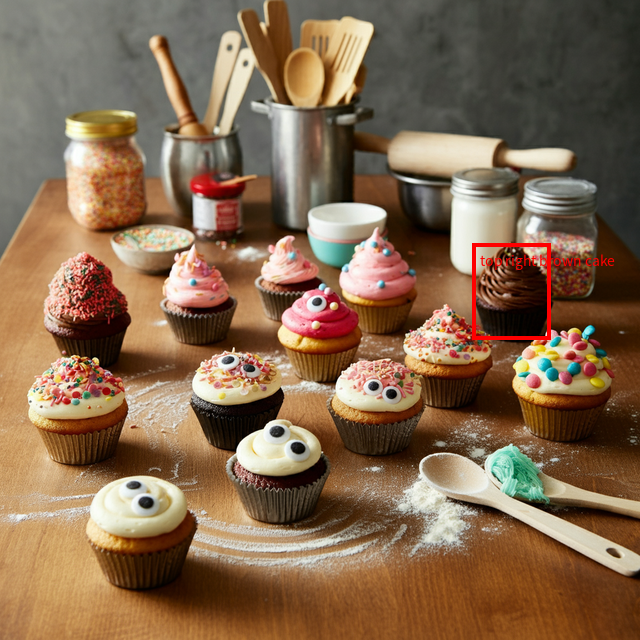

In [38]:
image_path = "./assets/spatial_understanding/cakes.png"

# prompt in chinses
prompt = "定位最右上角的棕色蛋糕，以JSON格式输出其bbox坐标"
# prompt in english
prompt = "Locate the top right brown cake, output its bbox coordinates using JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 3. Point to certain objects in xml format

In addition to the above mentioned bbox format [x1, y1, x2, y2], Qwen2.5-VL also supports point-based grounding. You can point to a specific object and the model is trained to output xml-style results.

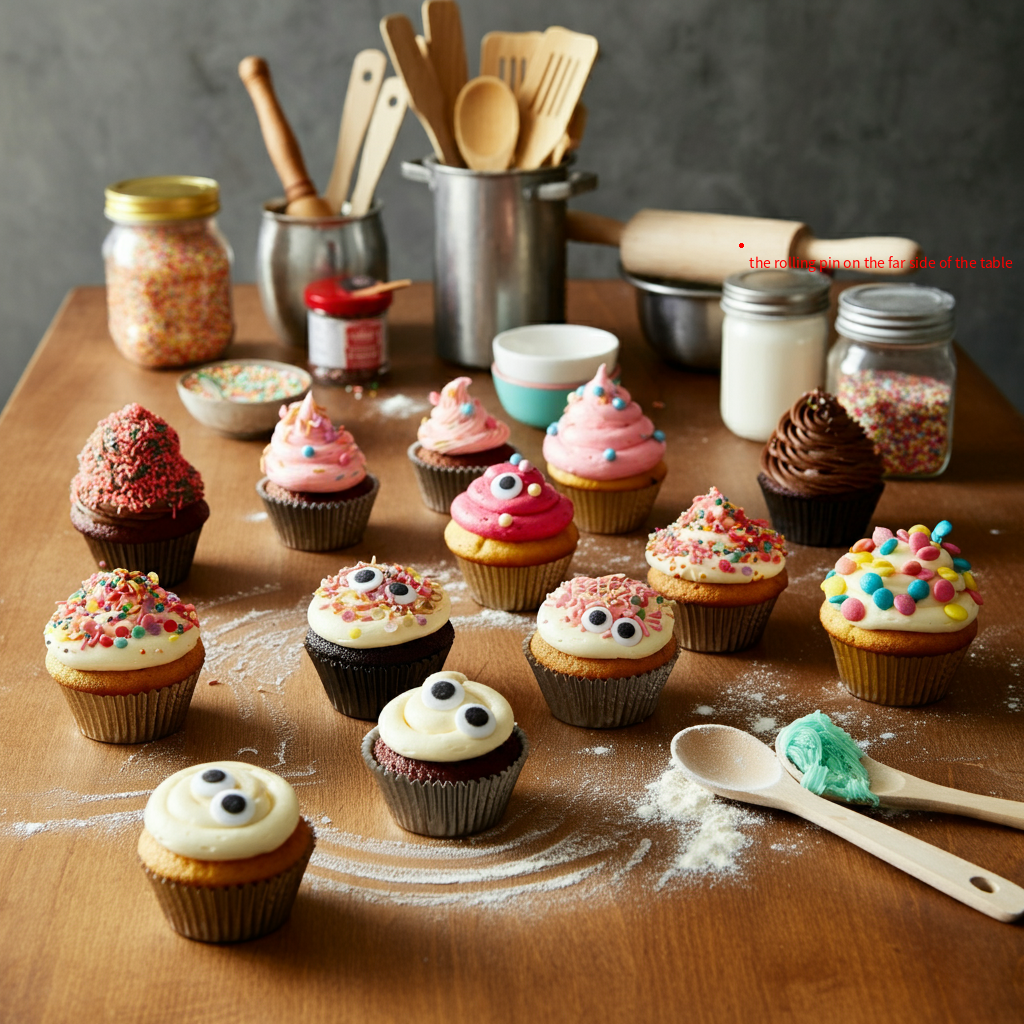

In [40]:
image_path = "./assets/spatial_understanding/cakes.png"

# prompt in chinese
prompt = "以点的形式定位图中桌子远处的擀面杖，以XML格式输出其坐标"
# prompt in english
prompt = "point to the rolling pin on the far side of the table, output its coordinates in XML format <points x y>object</points>"

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_points(image, response, input_width, input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_points(image, response, input_width, input_height)

#### 4. Reasoning capability

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the shadow of the paper fox, report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [1098, 1304, 1576, 1900], "label": "shadow of the paper fox"}
]
```
(640, 482)


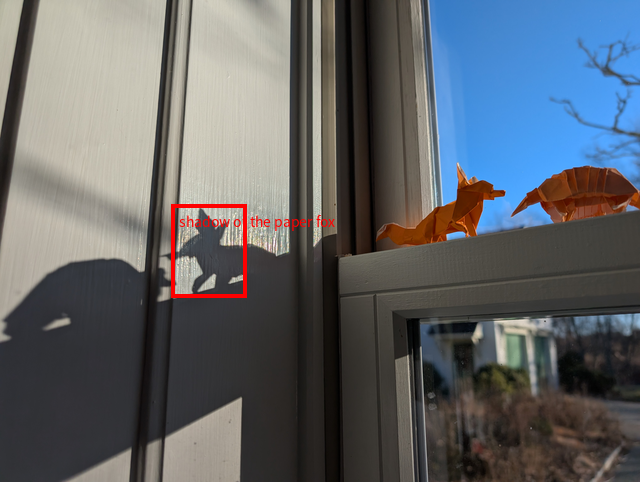

In [50]:
image_path = "./assets/spatial_understanding/Origamis.jpg"

# prompt in chinese
prompt = "框出图中纸狐狸的影子，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the shadow of the paper fox, report the bbox coordinates in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 5. Understand relationships across different instances

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the person who act bravely, report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [74, 58, 526, 623], "label": "person who acts bravely"}
]
```
(640, 360)


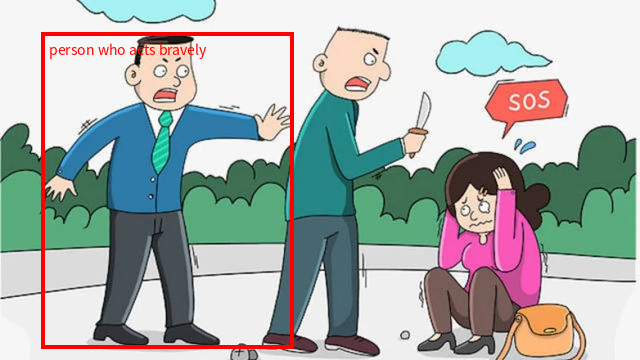

In [46]:
image_path = "./assets/spatial_understanding/cartoon_brave_person.jpeg"

# prompt in chinese
prompt = "框出图中见义勇为的人，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the person who act bravely, report the bbox coordinates in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 6. Find a special instance with unique characteristic (color, location, utility, ...)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its name and output in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [150, 196, 308, 310], "label": "sunglasses"}
]
```
(640, 465)


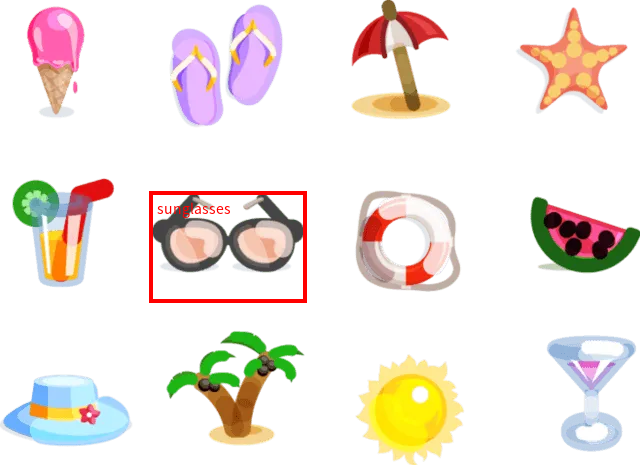

In [31]:
url = "./assets/spatial_understanding/multiple_items.png"

# prompt in chinese
prompt = "如果太阳很刺眼，我应该用这张图中的什么物品，框出该物品在图中的bbox坐标，并以json格式输出"
# prompt in english
prompt = "If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its name and output in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 7. Use Qwen2.5-VL grounding capabilities to help counting

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Please first output bbox coordinates and names of every item in this image in JSON format, and then answer how many items are there in the image.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
    {"bbox_2d": [25, 6, 87, 124], "label": "ice cream"},
    {"bbox_2d": [169, 3, 288, 130], "label": "flip-flops"},
    {"bbox_2d": [348, 0, 456, 124], "label": "beach umbrella"},
    {"bbox_2d": [519, 5, 634, 124], "label": "starfish"},
    {"bbox_2d": [14, 182, 118, 297], "label": "cocktail drink"},
    {"bbox_2d": [149, 196, 308, 283], "label": "sunglasses"},
    {"bbox_2d": [353, 196, 467, 300], "label": "lifebuoy"},
    {"bbox_2d": [530, 196, 644, 297], "label": "watermelon slice"},
    {"bbox_2d": [2, 383, 134, 476], "label": "hat"},
    {"bbox_2d": [168, 336, 308, 460], "label": "palm tree"},
    {"bbox_2d": [353, 364, 467, 476], "label": "sun"},
    {"bbox_2d"

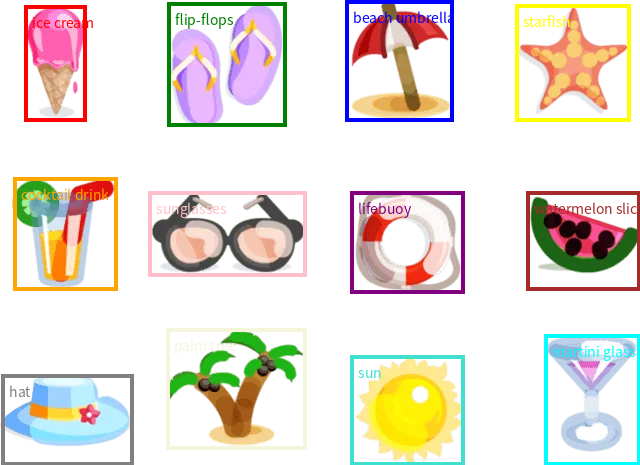

In [48]:
image_path = "./assets/spatial_understanding/multiple_items.png"

# prompt in chinese
prompt = "请以JSON格式输出图中所有物体bbox的坐标以及它们的名字，然后基于检测结果回答以下问题：图中物体的数目是多少？"
# prompt in english
prompt = "Please first output bbox coordinates and names of every item in this image in JSON format, and then answer how many items are there in the image."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

# # Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 8. spatial understanding with designed system prompt
The above usage is based on the default system prompt. You can also change the system prompt to obtain other output format like plain text.
Qwen2.5-VL now support these formats:
* bbox-format: JSON

`{"bbox_2d": [x1, y1, x2, y2], "label": "object name/description"}`

* bbox-format: plain text

`x1,y1,x2,y2 object_name/description`

* point-format: XML

`<points x y>object_name/description</points>`

* point-format: JSON

`{"point_2d": [x, y], "label": "object name/description"}`

Change your system prompt to use plain text as output format

In [56]:
image_path = "./assets/spatial_understanding/cakes.png"
image = Image.open(image_path)
system_prompt = "As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format 'x1,y1,x2,y2 object'."
prompt = "find all cakes"
response, input_height, input_width = inference(image_path, prompt, system_prompt=system_prompt)



## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# response = inference_with_api(image_path, prompt, sys_prompt=system_prompt)
# print(response)


input:
 <|im_start|>system
As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format 'x1,y1,x2,y2 object'.<|im_end|>
<|im_start|>user
find all cakes<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 43,378,996,957 cakes

